In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [3]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [4]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

In [9]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Nie zapomnij o etykietach:

In [10]:
y_train = train_data["Survived"]

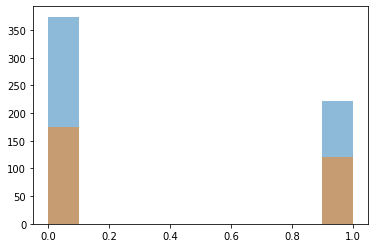

In [11]:
from sklearn.model_selection import train_test_split
train_data, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.33, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [12]:
train_data = train_data.drop("Survived",axis=1)
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
718,719,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
685,686,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
73,74,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
882,883,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S


Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [13]:
train_data["Pclass"].value_counts()

3    336
1    135
2    125
Name: Pclass, dtype: int64

In [14]:
train_data["Sex"].value_counts()

male      390
female    206
Name: Sex, dtype: int64

In [15]:
train_data["Embarked"].value_counts()

S    437
C    105
Q     53
Name: Embarked, dtype: int64

Atrybut **Embarked** mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
        ('standardscaler', StandardScaler())
    ])



In [18]:
num_pipeline.fit_transform(train_data)

array([[ 1.91349292, -0.46983664, -0.46399264,  0.38784185],
       [-0.09452019, -0.46983664, -0.46399264, -0.31908053],
       [-0.32621401,  0.34418265,  2.01618328,  0.18792449],
       ...,
       [ 0.90948636,  1.15820195, -0.46399264, -0.34613654],
       [-1.17575802,  0.34418265,  2.01618328,  1.71250117],
       [-0.63513911, -0.46983664,  0.77609532,  0.8821286 ]])

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [19]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [20]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ('standardscaler', StandardScaler())
    ])

In [21]:
cat_pipeline.fit_transform(train_data)

array([[ 1.84792176, -0.51516287, -1.13679712, ..., -0.46243841,
        -0.31241942,  0.60060852],
       [-0.54114845, -0.51516287,  0.87966444, ..., -0.46243841,
         3.20082537, -1.66497805],
       [-0.54114845,  1.94113369, -1.13679712, ...,  2.16245011,
        -0.31241942, -1.66497805],
       ...,
       [-0.54114845, -0.51516287,  0.87966444, ..., -0.46243841,
        -0.31241942,  0.60060852],
       [ 1.84792176, -0.51516287, -1.13679712, ..., -0.46243841,
        -0.31241942,  0.60060852],
       [ 1.84792176, -0.51516287, -1.13679712, ..., -0.46243841,
        -0.31241942,  0.60060852]])

Na koniec połączmy powyższe podejścia:

In [22]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Teraz mamy fajny **pipeline** przetwarzania wstępnego, który pobiera dane wejściowe i zwraca dane wyjściowe złorzone z liczb, które możemy podać do dowolnego modelu uczenia maszynowego.

In [23]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(train_data, y_train)
grid_1.best_params_

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

{'classifier__C': 0.1}

In [25]:


pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', SVC(C=1, probability=True))])

param_grid_2 = {
            'classifier__C': [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(train_data, y_train)
grid_2.best_params_

{'classifier__C': 1, 'classifier__gamma': 0.1}

In [26]:
from sklearn.linear_model import LogisticRegression

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LogisticRegression(C=1))])

param_grid_3 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(train_data, y_train)
grid_3.best_params_

{'classifier__C': 1}

In [27]:
from sklearn.tree import DecisionTreeClassifier

pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', DecisionTreeClassifier())])

param_grid_5 = {
            'classifier__max_depth': [5,9,10,11,20,30],
            'classifier__min_samples_split': [2,3,5,10,20,30,40],
            'classifier__max_leaf_nodes': [3,4,10,14,15,16,20,30,40]
}


grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(train_data, y_train)
grid_5.best_params_

{'classifier__max_depth': 9,
 'classifier__max_leaf_nodes': 16,
 'classifier__min_samples_split': 2}

In [57]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_6 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))
                  ])

param_grid_6 = {'classifier__n_estimators': [100, 200, 500],
              'classifier__max_samples': [50, 100, 200],
              'classifier__base_estimator__max_depth':[10, 20]
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(train_data, y_train)
grid_6.best_params_


{'classifier__base_estimator__max_depth': 20,
 'classifier__max_samples': 200,
 'classifier__n_estimators': 500}

In [58]:
from sklearn.ensemble import RandomForestClassifier

pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_7 = {'classifier__n_estimators': [10, 50, 100],
              'classifier__max_leaf_nodes': [10, 20],
              'classifier__max_depth': [10, 20]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(train_data, y_train)
grid_7.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 50}

In [59]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
                ('grid_2', grid_2.best_estimator_), 
                ('grid_3', grid_3.best_estimator_), 
                ('grid_6', grid_6.best_estimator_),         
                ('grid_7', grid_7.best_estimator_),
               ],
    voting='soft')
voting_clf.fit(train_data, y_train)

VotingClassifier(estimators=[('grid_2',
                              Pipeline(memory=None,
                                       steps=[('preprocessing',
                                               FeatureUnion(n_jobs=None,
                                                            transformer_list=[('num_pipeline',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('select_numeric',
                                                                                                DataFrameSelector(attribute_names=['Age',
                                                                                                                                   'SibSp',
                                                                                                                                   'Parch',
                                           

In [60]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('BaggingClassifier', grid_6.best_estimator_))
models.append(('RandomForestClassifier', grid_7.best_estimator_))
models.append(('Voting',  voting_clf))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'SVM linear'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM linear'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

SVM linear
precision_score: 0.7980769230769231
recall_score: 0.6916666666666667
f1_score: 0.7410714285714285
accuracy_score: 0.8033898305084746
roc_auc_score: 0.8729047619047619
SVM rbf
precision_score: 0.8735632183908046
recall_score: 0.6333333333333333
f1_score: 0.7342995169082125
accuracy_score: 0.8135593220338984
roc_auc_score: 0.848
LR
precision_score: 0.8018867924528302
recall_score: 0.7083333333333334
f1_score: 0.7522123893805309
accuracy_score: 0.8101694915254237
roc_auc_score: 0.8729047619047619
DecisionTreeClassifier
precision_score: 0.7788461538461539
recall_score: 0.675
f1_score: 0.7232142857142857
accuracy_score: 0.7898305084745763
roc_auc_score: 0.8005476190476191
BaggingClassifier
precision_score: 0.8058252427184466
recall_score: 0.6916666666666667
f1_score: 0.7443946188340808
accuracy_score: 0.8067796610169492
roc_auc_score: 0.877095238095238
RandomForestClassifier
precision_score: 0.8837209302325582
recall_score: 0.6333333333333333
f1_score: 0.7378640776699028
accuracy

In [61]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear','SVM rbf','LR','DecisionTreeClassifier', 'BaggingClassifier','RandomForestClassifier','Voting'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,SVM linear,0.798077,0.691667,0.741071,0.803390,0.872905
1,SVM rbf,0.873563,0.633333,0.734300,0.813559,0.848000
2,LR,0.801887,0.708333,0.752212,0.810169,0.872905
3,DecisionTreeClassifier,0.778846,0.675000,0.723214,0.789831,0.800548
4,BaggingClassifier,0.805825,0.691667,0.744395,0.806780,0.877095
5,RandomForestClassifier,0.883721,0.633333,0.737864,0.816949,0.884976
6,Voting,0.855556,0.641667,0.733333,0.810169,0.890381


In [42]:
# grid_3.best_estimator_.predict(X_test)

SVM linear
SVM rbf
LR
DecisionTreeClassifier
BaggingClassifier
RandomForestClassifier
Voting


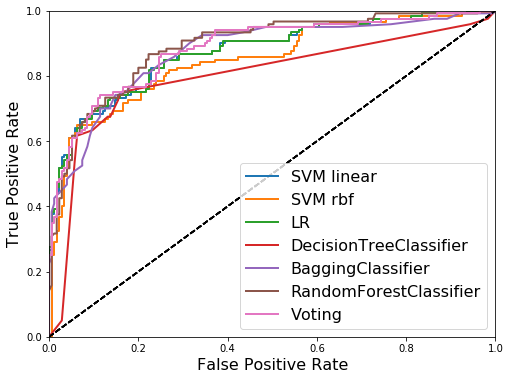

In [43]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
for name, model in models:
    print(name)
    if (name == 'SVM linear'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()
    

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_scores)

0.883095238095238